## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2022


# Homework 1: Let's GOOOOO!

- **100 points [7% of your final grade]**
- **Due Tuesday, February 13 by 11:59pm**

***Goals of this homework:***
1. Collect data from the web, clean it, and then make some observations based on exploratory data analysis
2. Understand and implement the classic apriori algorithm and extensions to find the association rules in a movie rating dataset

***Submission instructions:***

You should post your notebook to Canvas (look for the homework 1 assignment there). Please name your submission **your-uin_hw1.ipynb**, so for example, my submission would be something like **555001234_hw1.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that. 

***Late Days:***

As a reminder, you may use up to three of your late days on this homework, meaning the latest we will accept it is February 16 by 11:59pm.

***Collaboration declaration:***

If you worked with someone on this homework, please be sure to mention that. Remember to include citations to any sources you use in the homework.

## (50 points) Part 1: UFOs

### (10pts) Part 1a: UFOs are Out There, But First I Need to Store them Locally

For this first part, we're going to collect evidence of UFO sightings from the **National UFO Reporting Center**. Specifically, we're going 
to focus only on UFO sightings in Texas, as reported at this webpage:

* http://www.nuforc.org/webreports/ndxlTX.html

Recall that you can view the source of a webpage in Chrome under View &rarr; Developer &rarr; View Source. 
You'll notice, however, that this raw HTML is not in our friendly csv format and so will require some initial pre-processing. 
In particular, we're going to use the Python libraries **[requests](http://docs.python-requests.org/en/master/)** 
and **[beautiful soup](https://www.crummy.com/software/BeautifulSoup/)** to convert this UFO data from its original HTML format into csv. 

Hints:
* You'll notice that the column headers are in the `<TH>` tags.
* The values are in the `<TD>` tags.
* In beautiful soup, something like `.find_all('td')` may help you.
* To write the csv, you might want to `import csv` and take a look at the functions provided.
* If you google for "beautifulsoup table to csv" you should find some nice starting points.  Note, however, that you may not use an existing method that auto-magically converts the HTML into csv; we expect you to write your own code. If you borrow some elements from online resources, you should cite them in the comments. 

In [ ]:
import re
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# you should use requests to get the webpage, then extract 
# the appropriate column headings and rows
# then write this out to csv to a local file called 'ufos_in_texas.csv'

# GET request and content parsing using beautifulsoup
url = "http://www.nuforc.org/webreports/ndxlTX.html"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

body = soup.tbody
head = soup.thead

# get the column names
cols = []
for x in head.find_all("th"):
    cols.append(x.font.text)

# get the data
data = []
for x in body.find_all("tr"):
    val = []
    k = 1
    for v in x.find_all("td"):
        if k == 1:
            val.append(v.font.a.text)
            k += 1
        else:
            val.append(v.font.text)
    data.append(val)

# convert into pandas df
ufo_df = pd.DataFrame(data, columns=cols)
# sav dataframe into csv file
ufo_df.to_csv("/content/drive/MyDrive/Data Mining/HW1/ufos_in_texas.csv", header=cols, index=False)
print("UFO data saved in csv file: ufos_in_texas.csv!!!")

UFO data saved in csv file: ufos_in_texas.csv!!!


Once you have your local csv file, you should read it in and then issue the .head() command.

In [ ]:
# read the csv file saved
ufos_texas_original = pd.read_csv("/content/drive/MyDrive/Data Mining/HW1/ufos_in_texas.csv")

In [ ]:
ufos_texas_df = ufos_texas_original.copy()
ufos_texas_df.dropna(axis=0, subset=['Duration'], inplace=True)
ufos_texas_original.head()

,Date / Time,City,State,Shape,Duration,Summary,Posted
0,12/14/21 22:30,Dallas,TX,Formation,8 minutes,It was loud like rocket in a V shape.,12/19/21
1,12/12/21 17:30,Dallas,TX,Light,10 minutes,A light that was fading in and out.,12/19/21
2,12/9/21 16:30,Lazerbet,TX,Other,Google maping,It's big,12/19/21
3,12/9/21 16:00,Lazerbet,TX,Triangle,NaN,Unhuman,12/19/21
4,12/7/21 17:30,Oak Cliff,TX,Unknown,NaN,I was randomly taking pictures of the clouds a...,12/19/21


### (15pts) Part 1b: UFOs are a Mess! Time to Clean Up!

Okay, now we move to the fun part -- making sense of this messy data. These UFO reports are user-generated with little input validation. As a result, you will notice lots of oddities. 

Let's begin by focusing on the **Duration** column. As a first pass, let's make a grossly simplifying assumption -- that the only valid data is any duration that is of the form:  

* 1 second
* 2 seconds
* ...
* 1 minute
* 2 minutes
* ...
* 1 hour
* 2 hours 
* ...
* 1 day
* 2 days 
* ...

That is, we will only accept positive integers followed by a space, followed by a properly spelled unit. Every other entry is invalid. For example, that means these are all invalid durations:

* 1s
* 2 min.
* 2-3 seconds
* 10-15min
* 1 minute+
* 30 minutes and longer
* about 1.5 minutes

You may find the **pandas** library to be very helpful for this part. Create a new pandas dataframe that only includes sightings with these values, **where you convert all durations into seconds**. How many total rows are there in the original dataset? How many rows in your new 'validated' dataset? Report the basic statistics of the duration in your new 'validated' dataset (report maximum, minimum, mean, and standard deviation values of duration). At last, plot a boxplot of the duration (in seconds) in your 'validated' dataset.

In [ ]:
# function to convert duration to seconds as per the duration format
def convert(duration):
    dur = duration.split(" ")
    tim = dur[1].lower()
    if "minute" in tim:
        return float(dur[0])*60
    elif "hour" in tim:
        return float(dur[0])*3600
    else:
        return float(dur[0])

In [ ]:
# filter our invalid durations
# convert all valid durations to seconds

# use of regex to filter out invalid durations and keeping duration of format {<integer> <minute/hour/second>}
# the regex can take duration of format 1.5 hour
ufos_texas_valid = ufos_texas_df[ufos_texas_df['Duration'].str.match(r"^([0-9]+)(\.{0,1}[0-9]*)\s(minute|MINUTE|hour|HOUR|second|SECOND|day|DAY|week|WEEK|month|MONTH|year|YEAR)s{0,1}$")==True]
ufo_tx = ufos_texas_valid.copy()
ufo_tx['Duration'] = ufos_texas_valid['Duration'].apply(lambda x: convert(x))
print("Duration converted to seconds!!!")

Duration converted to seconds!!!


In [ ]:
ufo_tx.reset_index(inplace=True)
ufo_tx.head()

,index,Date / Time,City,State,Shape,Duration,Summary,Posted
0,0,12/14/21 22:30,Dallas,TX,Formation,480.0,It was loud like rocket in a V shape.,12/19/21
1,1,12/12/21 17:30,Dallas,TX,Light,600.0,A light that was fading in and out.,12/19/21
2,9,12/1/21 08:00,Austin,TX,Changing,5.0,((HOAX)) UFO on a star with men in red armore...,12/19/21
3,14,11/6/21 14:00,Abilene,TX,Changing,1800.0,"I was outside waiting on my ride, when a white...",11/15/21
4,16,10/25/21 17:18,Corpus Christi,TX,Other,2400.0,Seven United States Postal workers in Corpus C...,10/26/21


In [ ]:
# total rows in original dataset
# valid rows in your new 'validated' dataset

print("Rows in original dataset: ", len(ufos_texas_original))
print("Rows in validated dataset: ", len(ufo_tx))

Rows in original dataset:  5631
Rows in validated dataset:  2858


Basic statistics of duration in validated dataset: 
count      2858.000000
mean        863.243632
std        3924.117804
min           0.500000
25%          20.000000
50%         120.000000
75%         600.000000
max      172800.000000
Name: Duration, dtype: float64


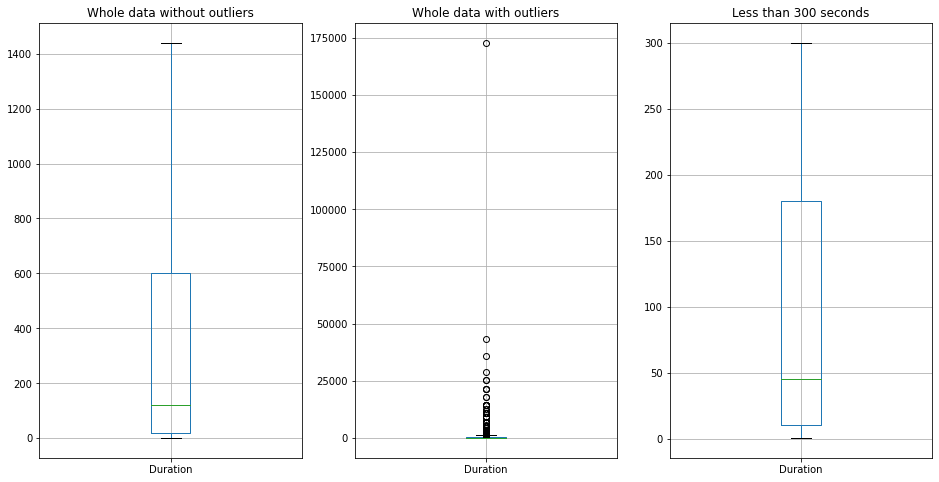

In [ ]:
# report the basic statistics of duration in 'validated' dataset
# boxplot code here

print("Basic statistics of duration in validated dataset: ")
print(ufo_tx['Duration'].describe())

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.title("Whole data without outliers")
bx1 = ufo_tx.boxplot(column=['Duration'], showfliers=False)

plt.subplot(1,3,2)
plt.title("Whole data with outliers")
bx2 = ufo_tx.boxplot(column=['Duration'])

ufo_tx_hour = ufo_tx[ufo_tx['Duration']<=300]
plt.subplot(1,3,3)
plt.title("Less than 300 seconds")
bx3 = ufo_tx_hour.boxplot(column=['Duration'])

### (15pts) Part 1c: Can we do better?
Interesting. But we threw away a **lot** of data. We can do better. For this part, you will do your best to clean up the durations from your original dataset. Keep in mind some initial guidelines:

* If a duration has a range, use the average as its value. For example, if the duration is listed as “6-8 minutes”, you should consider the duration as “7 minutes”. (Again, you will need to eventually convert minutes into seconds).
* If a duration has a “<” sign, you should simply ignore the “<” sign. For example if the duration is specified as “< 1 minute”, consider the duration to be “1 minute”. You should subsequently convert “1 minute” to "60 seconds".
* If a duration has a “>” sign, you should simply ignore the “>” sign. 
* You should ignore any row with an empty duration.

You will probably have to improvise as you go along, so **make detailed notes of what decisions you are making and why**.

In [ ]:
def validate_convert(duration):
    duration = duration.lower()
    duration = duration.replace("to", "-").replace("and", " ")
    
    valid = re.sub(r'[\+><}{\[\],\';:\"!~`]', "", duration)
    timeUnit = ['hour', 'minute', 'second', 'day', 'year', 'week', 'month']
    for t in timeUnit:
        valid = valid.replace(t, " " + t + " ")
    validSplit = valid.split()
    
    for i in range(len(validSplit)):
        if validSplit[i] == "-":
            if i > 0 and i < len(validSplit)-1 and validSplit[i-1].isdigit() and validSplit[i+1].isdigit():
                num = str((int(validSplit[i-1]) + int(validSplit[i+1]))/2.0)
                validSplit[i+1] = num
        elif "-" in validSplit[i]:
            v = validSplit[i].split("-")
            if v[0].isdigit() and v[1].isdigit() and len(v) == 2:
                num = str((int(v[0]) + int(v[1]))/2.0)
                validSplit[i] = num
    
    durationSeconds = 0
    unitConvert = {'second': 1, 'minute': 60, 'hour': 3600, 'day': 24*3600, 'week': 7*24*3600, 'month': 30*7*24*3600, 'year': 365*24*3600}
    for i in range(1, len(validSplit)):
        if 'hour' in validSplit[i] and validSplit[i-1].replace('.', '', 1).isdigit():
            durationSeconds += 3600*float(validSplit[i-1])
        elif 'minute' in validSplit[i] and validSplit[i-1].replace('.', '', 1).isdigit():
            durationSeconds += 60*float(validSplit[i-1])
        elif 'second' in validSplit[i] and validSplit[i-1].replace('.', '', 1).isdigit():
            durationSeconds += float(validSplit[i-1])
        elif 'week' in validSplit[i] and validSplit[i-1].replace('.', '', 1).isdigit():
            durationSeconds += float(validSplit[i-1])
        elif 'month' in validSplit[i] and validSplit[i-1].replace('.', '', 1).isdigit():
            durationSeconds += float(validSplit[i-1])
        elif 'year' in validSplit[i] and validSplit[i-1].replace('.', '', 1).isdigit():
            durationSeconds += float(validSplit[i-1])
    return durationSeconds

In [ ]:
ufos_texas_df

,Date / Time,City,State,Shape,Duration,Summary,Posted
0,12/14/21 22:30,Dallas,TX,Formation,8 minutes,It was loud like rocket in a V shape.,12/19/21
1,12/12/21 17:30,Dallas,TX,Light,10 minutes,A light that was fading in and out.,12/19/21
2,12/9/21 16:30,Lazerbet,TX,Other,Google maping,It's big,12/19/21
5,12/3/21 21:00,Sanderson,TX,Light,~1 minute,Sighting of odd light in night sky.,12/19/21
9,12/1/21 08:00,Austin,TX,Changing,5 years,((HOAX)) UFO on a star with men in red armore...,12/19/21
...,...,...,...,...,...,...,...
5624,13:30,Pearland,TX,Unknown,One to two minutes.,A late July or August weekday afternoon betwee...,6/4/04
5626,01:00,San Angelo,TX,Triangle,5 min or more,"Several years ago, my husband and I was settin...",5/24/05
5627,1975-1976,Odessa,TX,NaN,3 to 5 minutes??,"I have more than one event to report, but I wi...",8/5/01
5629,NaN,Austin,TX,Light,10 minutes,Bright hovering light downtown Austin,8/24/10


# Procedure followed for data cleaning
1) Using the regex below, the data is cleaned

2) 'apply' and 'validate_convert' function is used to convert the durations into seconds. Seconds, minutes, hours, days, weeks, months, years are taken into consideration. A check is done to check whether an integer or float or values like 1-2 are taken into consideration. Then using the appropriate time period, the duration is converted into seconds.

3) Duration (in seconds) of 0 are ignored after the cleaning. 

4) The basic statistics of the Duration data is then calculated along with the box plots

In [ ]:
# clean data 
# convert cleaned durations to seconds
# use of regex to clean the data that checks if there is any digits and other keywords present in the duration string
ufo_tx_det = ufos_texas_df[ufos_texas_df['Duration'].str.match(r"([0-9]+)(\.{0,1}[0-9]*).*")==True]
ufo_tx_detail = ufo_tx_det.copy()
ufo_tx_detail['Duration'] = ufo_tx_det['Duration'].apply(lambda x: validate_convert(x))
ufo_tx_detail = ufo_tx_detail[ufo_tx_detail['Duration'] > 0]

In [ ]:
# total rows in original dataset
# valid rows in your cleaned dataset

print("Rows in original dataset: ", len(ufos_texas_df))
print("Rows in new cleaned dataset: ", len(ufo_tx_detail))

Rows in original dataset:  5404
Rows in new cleaned dataset:  3624


Basic statistics of duration in validated dataset: 
count      3624.000000
mean        985.961313
std        7057.163668
min           0.500000
25%          20.000000
50%         150.000000
75%         600.000000
max      360000.000000
Name: Duration, dtype: float64


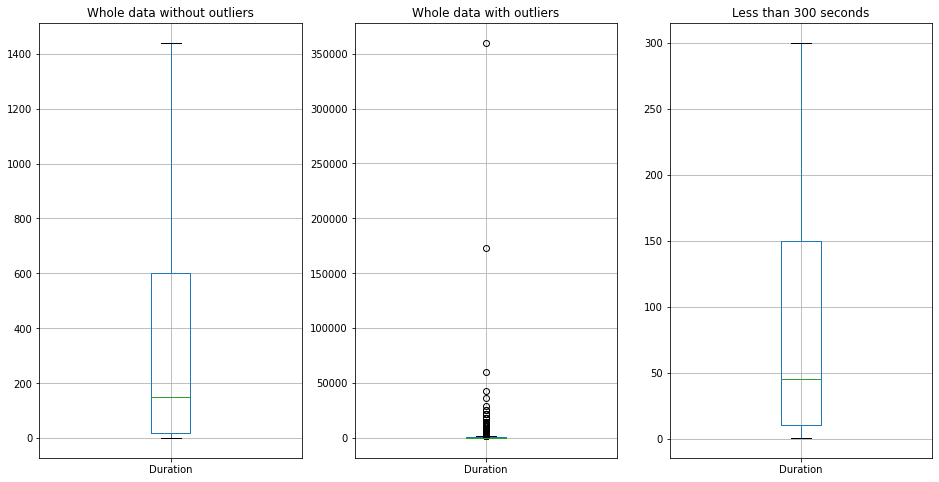

In [ ]:
# report the basic statistics of duration in your cleaned dataset
# draw a boxplot for your cleaned dataset

print("Basic statistics of duration in validated dataset: ")
print(ufo_tx_detail['Duration'].describe())

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.title("Whole data without outliers")
bx1 = ufo_tx_detail.boxplot(column=['Duration'], showfliers=False)

plt.subplot(1,3,2)
plt.title("Whole data with outliers")
bx2 = ufo_tx_detail.boxplot(column=['Duration'])

ufo_tx_detail_hour = ufo_tx_detail[ufo_tx_detail['Duration']<=300]
plt.subplot(1,3,3)
plt.title("Less than 300 seconds")
bx3 = ufo_tx_detail_hour.boxplot(column=['Duration'])

In [ ]:
ufo_tx_detail_check = ufo_tx_detail[ufo_tx_detail['Duration']<150]
print(len(ufo_tx_detail_check), len(ufo_tx_detail), len(ufo_tx_detail_check)/len(ufo_tx_detail)*100.0)

1792 3624 49.448123620309055


### (5pts) Part 1d: Observations and Conclusions

Based on your analysis on part 1b and 1c, what observations or conclusions can you make from the data?

1) Around 50% of the data has duration within 300 seconds.

2) The max duration changes by almost twice on further cleaning the data, with ~50% of the data having duration less than 150 seconds.

3) The median of the duration from the observations of 1b and 1c has low difference. 

4) Almost 50% of the duration are in proper format, i.e. <int/float minutes/seconds/hours/weeks/months/years>

5) There are 227 records that don't have any duration mentioned.

### (5pts) Part 1e: Next Steps

Now is your chance to conduct an interesting analysis on the UFO data you have collected. This is open-ended, so you may choose whatever direction you like. For example, you might want to take a look at the shape of the UFOs or perhaps the temporal aspects of the reports. 

In [ ]:
# number of records without any duration
ufos_texas_original['Duration'].isna().sum()

227

In [ ]:
# top 10 cities having high UFO sightings
df_group_sort = ufos_texas_original.groupby(['City']).size().sort_values(ascending=False).reset_index().rename(columns={0: 'UFO sightings count'})
df_group_sort.head(10)

,City,UFO sightings count
0,Houston,407
1,Austin,324
2,San Antonio,259
3,Dallas,202
4,El Paso,121
5,Fort Worth,113
6,Arlington,79
7,Corpus Christi,79
8,Katy,60
9,Plano,59


In [ ]:
df_shape = ufos_texas_original.groupby(['Shape']).size().reset_index().rename(columns={0: 'shape count'})
print("Number of unique shapes: ", len(df_shape['Shape'].unique()), "\n", df_shape['Shape'].unique())

Number of unique shapes:  29 
 ['Changing' 'Chevron' 'Cigar' 'Circle' 'Cone' 'Cross' 'Cylinder' 'Delta'
 'Diamond' 'Disk' 'Egg' 'Fireball' 'Flash' 'Formation' 'Light' 'Other'
 'Oval' 'Rectangle' 'Sphere' 'Teardrop' 'Triangle' 'Unknown' 'cigar'
 'diamond' 'light' 'other' 'rectangle' 'sphere' 'triangle']


In [ ]:
# top 10 UFO shapes reported
df_shape = df_shape.sort_values(ascending=False, by=['shape count']).reset_index().drop(columns=['index'])
df_shape[:10]

,Shape,shape count
0,Light,1136
1,Triangle,560
2,Circle,520
3,Other,440
4,Unknown,427
5,Disk,344
6,Sphere,342
7,Fireball,302
8,Oval,299
9,Formation,188


# *tell us what next steps you took, and what you discovered*

The Shape of UFO sighted and reported, and the City where these sightings occured were analyzed leading to the following results (The calculations of these is present in above cells under 1e):

1) 227 records do not have any duration

2) Houston reported maximum number of sightings, 407

3) *Light* shape of UFO is reported to be sighted maximum times out of 29 different kind of shapes that includes some interesting shapes like egg shape, disk shape, diamond shape, teardrop shape, delta shape.

## (50 points) Part 2: Association Rules in Movie Rating Behaviors

For the second part of this homework, we're going to examine movies using our understanding of association rules, to find movies that "go together". For this part, you will implement the apriori algorithm, and apply it to a movie rating dataset. We'll use the [MovieLens](https://grouplens.org/datasets/movielens/) dataset.

First, run the next cell to load the dataset we are going to use.

In [ ]:
import urllib3
import zipfile
import os

http = urllib3.PoolManager()
req = http.request("GET", "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip", preload_content=False)

with open("/content/drive/MyDrive/Data Mining/HW1/movie.zip", 'wb') as out:
  while True:
    data = req.read(4096)
    if not data:
      break
    out.write(data)
req.release_conn()

zFile = zipfile.ZipFile("/content/drive/MyDrive/Data Mining/HW1/movie.zip", "r")
# print(zFile.namelist())
for fileM in zFile.namelist():
  zFile.extract(fileM, path="/content/drive/MyDrive/Data Mining/HW1")

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [ ]:
!ls "/content/drive/MyDrive/Data Mining/HW1/"ml-latest-small/

links.csv  movies.csv  ratings.csv  README.txt	tags.csv


In this dataset, there are four columns: `userId` is the integer ids of users, `movieId` is the integer ids of movies, `rating` is the rate of the user gives to the movie, and `timestamp` which we do not use here. Each row denotes that the user of given `userId` rated the movie of the given `movieId`. We are going to treat each user as a "basket", so you will need to collect all the movies that have been rated by a single user as a basket. 

Now, you need to implement the apriori algorithm and apply it to this dataset to find association rules of user rating behaviors where:

1. Define `rating` >= 3 is "like" (that is, only consider movie ratings of 3 or higher in your baskets; you may ignore all others)
2. `minsup` == 40 (out of 600 users/baskets); we may adjust this based on the discussion on Campuswire
3. `minconf` == to be determined by a discussion on Campuswire. You may try several different choices, but we will converge on a good choice for everyone for the final submission.
 
We know there are many existing implementations of apriori online (check github for some good starting points). You are welcome to read existing codebases and let that inform your approach. Do not copy-paste any existing code. We want your code to have sufficient comments to explain your steps, to show us that you really know what you are doing. Furthermore, you should add print statements to print out the intermediate steps of your method -- e.g., the size of the candidate set at each step of the method, the size of the filtered set, and any other important information you think will highlight the method. 

To help get you started, we can load the ratings with the following code snippet:

In [ ]:
import pandas as pd
# read user ratings
allRatings = pd.read_csv("/content/drive/MyDrive/Data Mining/HW1/ml-latest-small/ratings.csv")
allRatings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [ ]:
allMovies = pd.read_csv("/content/drive/MyDrive/Data Mining/HW1/ml-latest-small/movies.csv")
allMovies = allMovies.set_index("movieId")
allMovies

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
193585,Flint (2017),Drama


### (15pts) Step 1: Implement Apriori Algorithm
In this section, you need to implement the Apriori algorithm, we will check the correctness of your code and we encourage efficient implementation and skills of pruning.

In [ ]:
import random
import numpy as np
import pandas as pd
from datetime import datetime
from itertools import combinations

class Apriori:
    def __init__(self):
        self.movie_data = None
        self.dataset_size = None


    def read(self, movies_path, ratings_path):
        # read all movie name data
        print("#################### DATA READ ####################")
        all_movies = pd.read_csv(movies_path)
        all_movies = all_movies.set_index("movieId")
        print("Movie name and genre data read successfully!!!")
        # ead user ratings data
        all_ratings = pd.read_csv(ratings_path)
        print("Ratings data read successfully!!!")
        self.dataset_size = len(all_ratings['userId'].unique())
        return all_ratings, all_movies


    def sampling(self, all_ratings, alpha=0.6):
        print("#################### DATA SAMPLING ####################")
        unique_user_id = set(all_ratings['userId'])
        removed_user_id = random.sample(unique_user_id, int((1-alpha)*len(unique_user_id)))
        print("Number of unique user ids before sampling: ", len(unique_user_id))
        all_ratings = all_ratings[~all_ratings['userId'].isin(removed_user_id)]
        print("Number of user id to be removed for sampling: ", len(removed_user_id))
        unique_user_id = set(all_ratings['userId'])
        print("Number of unique user ids after sampling: ", len(unique_user_id))
        return all_ratings


    def print_rules(self, rules, all_movies):
        print("#################### ASSOCIATION RULES ####################")
        # print the association rules with movie names
        for i, movie_ids in enumerate(rules):
            length = len(movie_ids)
            print((i+1), end=") ")
            for idx in range(length):
                print(all_movies.loc[movie_ids[idx]]['title'], end="")
                if idx == len(movie_ids) - 2:
                    print(" -> ", end='')
                elif idx != len(movie_ids) - 1:
                    print(" , ", end="")
            print()
            

    def basket_count(self, movie_id):
        m_id = list(movie_id)
        m_intersection = self.movie_data['userGroup'][m_id[0]]
        for movie in m_id[1:]:
            m_intersection = m_intersection.intersection(self.movie_data['userGroup'][movie])
        return len(m_intersection)*1.0/self.dataset_size


    def preprocessing(self, rating_data, min_supp=0.16):
        print("#################### DATA PREPROCESSING ####################")
        # preprocessing
        start = datetime.now()
        # removing all movies that has rating < 3
        rating_data = rating_data[rating_data['rating']>=3]

        # group movies as per the movieId to combine the user ids into a set to know the users that have rated that movie
        rating_group_data = rating_data.groupby('movieId')['userId'].apply(set).reset_index(name="userGroup")
        rating_group_data['supp'] = rating_group_data['userGroup'].apply(lambda x: len(x)*1.0/self.dataset_size)

        # remove the movieIds where the support is less than minSupp
        rating_group_data = rating_group_data[rating_group_data['supp'] >= min_supp].set_index('movieId')

        time_diff = (datetime.now() - start).total_seconds()
        print("Time taken for initial data processing: {} seconds".format(time_diff))

        return rating_group_data


    def apriori(self, rating_group_data, min_supp=0.16, min_conf=0.95):
        print("#################### APRIORI ####################")
        self.movie_data = rating_group_data.copy()
        movie_combination = set(list(rating_group_data.index))
        assoc_count = 2
        rules = list()
        movie_data_prev = rating_group_data['supp'].copy()

        while len(movie_combination) > 0:
            print("Calculation for {}-itemset!!!".format(assoc_count))
            # create a dataframe containing the associations as per the association count
            group_movies_inter = None
            group_movies_inter = pd.Series(list(combinations(list(movie_combination), assoc_count))).to_frame("movieId")
            print("Initial candidate itemsets of {}-association: {}".format(assoc_count, len(group_movies_inter)))
            # create set of user groups for each association set and find out the count of each association set as per the no. of users rated
            start = datetime.now()
            group_movies_inter['supp'] = group_movies_inter['movieId'].apply(lambda x: self.basket_count(x))
            time_diff = ((datetime.now() - start).total_seconds())/60.0
            print("Time taken to calculate the user basket count: {} minutes".format(time_diff))
            # group_movies_inter['supp'] = group_movies_inter['userGroup'].apply(lambda x: len(x))
            group_movies_inter = group_movies_inter[group_movies_inter['supp'] >= min_supp]
            print("Final Candidate set of {}-associations >= {}(minSup) found: {}".format(assoc_count, min_supp, len(group_movies_inter)))

            # add the association rules into the association rule list
            if len(group_movies_inter) == 0:
                break
            start = datetime.now()
            group_movies_inter = group_movies_inter.reset_index(drop=True).set_index('movieId')
            for movie_id in group_movies_inter.index:
                idx = tuple(sorted(movie_id))
                for mid in list(combinations(idx, assoc_count-1)):
                    if len(mid) == 1:
                        denominator = movie_data_prev.loc[mid]
                    else:
                        denominator = movie_data_prev.loc[[mid]].iloc[0]['supp']
                    conf = group_movies_inter.loc[[movie_id]].iloc[0]['supp'] * 1.0 / denominator
                    if conf >= min_conf:
                        final = list(mid)
                        final.extend(list(set(idx).difference(set(final))))
                        rules.append(tuple(final))
            print("Length of association rules: ", len(rules))
            time_diff = ((datetime.now() - start).total_seconds())/60.0
            print("Time taken to get the association rules with minimum confidence of {}: {} minutes".format(min_conf, time_diff))

            # get the unique movie ids after the association
            movie_combination = set()
            for x in list(group_movies_inter.index):
                movie_combination = movie_combination.union(set(x))
            print("Number of unique movie ids left after {}-association: {}".format(assoc_count, len(movie_combination)))
            # update the previous dataframe of movie Id and their support
            movie_data_prev = None
            movie_data_prev = group_movies_inter[['supp']].copy().reset_index(drop=False)
            movie_data_prev['movieId'] = movie_data_prev['movieId'].apply(lambda x: tuple(sorted(x)))
            movie_data_prev = movie_data_prev.set_index('movieId')
            assoc_count += 1
        print("Total association rules found: {}\n".format(len(rules)))
        return rules

In [ ]:
# hyperparameters
minSupp = 0.24 # minimum support count = 150
minConf = 0.80
movies_path = "/content/drive/MyDrive/Data Mining/HW1/ml-latest-small/movies.csv"
ratings_path = "/content/drive/MyDrive/Data Mining/HW1/ml-latest-small/ratings.csv"

candidate = Apriori()
all_ratings, all_movies = candidate.read(movies_path, ratings_path)
rating_group_data = candidate.preprocessing(all_ratings, minSupp)
rules_set = candidate.apriori(rating_group_data, minSupp, minConf)

#################### DATA READ ####################
Movie name and genre data read successfully!!!
Ratings data read successfully!!!
#################### DATA PREPROCESSING ####################
Time taken for initial data processing: 0.369344 seconds
#################### APRIORI ####################
Calculation for 2-itemset!!!
Initial candidate itemsets of 2-association: 703
Time taken to calculate the user basket count: 0.00032326666666666665 minutes
Final Candidate set of 2-associations >= 0.24(minSup) found: 31
Length of association rules:  12
Time taken to get the association rules with minimum confidence of 0.8: 0.0005231833333333334 minutes
Number of unique movie ids left after 2-association: 19
Calculation for 3-itemset!!!
Initial candidate itemsets of 3-association: 969
Time taken to calculate the user basket count: 0.0006044166666666666 minutes
Final Candidate set of 3-associations >= 0.24(minSup) found: 2
Length of association rules:  14
Time taken to get the association rul

### (5pts) Step 2: Print Your Association Rules

Next you should print your final association rules in the following format:

**movie_name_1, movie_name_2, ... --> 
movie_name_k**

where the movie names can be fetched by joining the movieId with the file `movies.csv`. For example, one rule that you might find is:

**Matrix, The (1999),  Star Wars: Episode V - The Empire Strikes Back (1980),  Star Wars: Episode IV - A New Hope (1977),  -> 
Star Wars: Episode VI - Return of the Jedi (1983)**

In [ ]:
candidate.print_rules(rules_set, all_movies)

#################### ASSOCIATION RULES ####################
1) Lord of the Rings: The Fellowship of the Ring, The (2001) -> Lord of the Rings: The Two Towers, The (2002)
2) Lord of the Rings: The Two Towers, The (2002) -> Lord of the Rings: The Fellowship of the Ring, The (2001)
3) Lord of the Rings: The Fellowship of the Ring, The (2001) -> Lord of the Rings: The Return of the King, The (2003)
4) Lord of the Rings: The Return of the King, The (2003) -> Lord of the Rings: The Fellowship of the Ring, The (2001)
5) Star Wars: Episode V - The Empire Strikes Back (1980) -> Star Wars: Episode IV - A New Hope (1977)
6) Star Wars: Episode VI - Return of the Jedi (1983) -> Star Wars: Episode IV - A New Hope (1977)
7) Apollo 13 (1995) -> Forrest Gump (1994)
8) Seven (a.k.a. Se7en) (1995) -> Pulp Fiction (1994)
9) Star Wars: Episode VI - Return of the Jedi (1983) -> Star Wars: Episode V - The Empire Strikes Back (1980)
10) Lord of the Rings: The Two Towers, The (2002) -> Lord of the Rings: The R

### (15pts) Step 3: Implement Random Sampling

We discussed in class a method to randomly sample baskets to avoid the overhead of reading the entire set of baskets (which in practice, could amount to billions of baskets). For this part, you should implement such a random sampling approach that takes a special parameter **alpha** that controls the size of the sample: e.g., alpha = 0.10 means to sample 10% of the baskets (our users, in this case). 

Vary **alpha** and report the number of frequent itemsets you find and how this compares to the number of frequent itemsets in the entire dataset. What do you discover?


NOTE: Random sampling is implemented as function sampling in the apriori algorithm implementation

In [ ]:
movies_path = "/content/drive/MyDrive/Data Mining/HW1/ml-latest-small/movies.csv"
ratings_path = "/content/drive/MyDrive/Data Mining/HW1/ml-latest-small/ratings.csv"

alpha_list = [1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6]
minSup, minConf = 0.165, 0.90
set_count_alpha = dict()
for alpha in alpha_list:
    candidate = Apriori()
    all_ratings, all_movies = candidate.read(movies_path, ratings_path)
    all_ratings = candidate.sampling(all_ratings, alpha)
    rating_group_data = candidate.preprocessing(all_ratings, minSup)
    rules_set = candidate.apriori(rating_group_data, minSup, minConf)
    print("Number of association rules for minSup={}, minConf={}, and alpha={}: {}\n".format(minSup, minConf, alpha, len(rules_set)))
    set_count_alpha[alpha] = rules_set
# candidate.print_rules(rules_set, all_movies)

#################### DATA READ ####################
Movie name and genre data read successfully!!!
Ratings data read successfully!!!
#################### DATA SAMPLING ####################
Number of unique user ids before sampling:  610
Number of user id to be removed for sampling:  0
Number of unique user ids after sampling:  610
#################### DATA PREPROCESSING ####################
Time taken for initial data processing: 0.332795 seconds
#################### APRIORI ####################
Calculation for 2-itemset!!!
Initial candidate itemsets of 2-association: 4560
Time taken to calculate the user basket count: 0.00338675 minutes
Final Candidate set of 2-associations >= 0.165(minSup) found: 294
Length of association rules:  2
Time taken to get the association rules with minimum confidence of 0.9: 0.008824783333333334 minutes
Number of unique movie ids left after 2-association: 57
Calculation for 3-itemset!!!
Initial candidate itemsets of 3-association: 29260
Time taken to calcu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Time taken for initial data processing: 0.15847 seconds
#################### APRIORI ####################
Calculation for 2-itemset!!!
Initial candidate itemsets of 2-association: 1431
Time taken to calculate the user basket count: 0.0006115833333333333 minutes
Final Candidate set of 2-associations >= 0.165(minSup) found: 82
Length of association rules:  0
Time taken to get the association rules with minimum confidence of 0.9: 0.0013623166666666667 minutes
Number of unique movie ids left after 2-association: 26
Calculation for 3-itemset!!!
Initial candidate itemsets of 3-association: 2600
Time taken to calculate the user basket count: 0.0015205166666666667 minutes
Final Candidate set of 3-associations >= 0.165(minSup) found: 15
Length of association rules:  7
Time taken to get the association rules with minimum confidence of 0.9: 0.0007649333333333334 minutes
Number of unique movie ids left after 3-association: 16
Calculation for 4-itemset!!!
Initial candidate itemsets of 4-association

In [ ]:
print("Frequent itemset details for MinSup: ", minSup, "and minConf:", minConf)
print("Alpha\tNumber of frequent itemsets\tOriginal number of frequent itemsets")
for x, val in set_count_alpha.items():
    print(x, "\t\t", len(val), "\t\t\t\t", len(set_count_alpha[1]))

Frequent itemset details for MinSup:  0.165 and minConf: 0.9
Alpha	Number of frequent itemsets	Original number of frequent itemsets
1 		 89 				 89
0.95 		 55 				 89
0.9 		 29 				 89
0.85 		 19 				 89
0.8 		 7 				 89
0.75 		 10 				 89
0.7 		 2 				 89
0.65 		 0 				 89
0.6 		 0 				 89


# *Discussion*

On keeping the minSupp and minConf values same and changing the alpha value, it can be noticed that as alpha value is decreased  (number of random samples from baskets is decreased), the number of frequent itemsets generated by Apriori algorithm gets decreased and eventually becomes 0. This observation is based on the smaller dataset on multiple different values of minSupp and minConf.

### (10pts) Step 4: Check for False Positives

Next you should verify that the candidate pairs you discover by random sampling are truly frequent by comparing to the itemsets you discover over the entire dataset. 

For this part, consider another parameter **minsup_sample** that relaxes the minimum support threshold. For example if we want minsup = 1/100 for whole dataset, then try minsup_sample = 1/125 for the sample. This will help catch truly frequent itemsets.

Vary **minsup_sample** and report the number of frequent itemsets you find and the number of false positives you find. What do you discover?


In [ ]:
movies_path = "/content/drive/MyDrive/Data Mining/HW1/ml-latest-small/movies.csv"
ratings_path = "/content/drive/MyDrive/Data Mining/HW1/ml-latest-small/ratings.csv"

alpha_list = [1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2]
minSup, minConf = 0.165, 0.85
minsup_sample = minSup
set_count_alpha = dict()
for alpha in alpha_list:
    if alpha != 1:
        minsup_sample = minSup - 0.03
    candidate = Apriori()
    all_ratings, all_movies = candidate.read(movies_path, ratings_path)
    all_ratings = candidate.sampling(all_ratings, alpha)
    rating_group_data = candidate.preprocessing(all_ratings, minsup_sample)
    rules_set = candidate.apriori(rating_group_data, minsup_sample, minConf)
    print("Number of association rules for minsup_sample={}, minConf={}, and alpha={}: {}".format(minsup_sample, minConf, alpha, len(rules_set)))
    set_count_alpha[alpha] = rules_set

#################### DATA READ ####################
Movie name and genre data read successfully!!!
Ratings data read successfully!!!
#################### DATA SAMPLING ####################
Number of unique user ids before sampling:  610
Number of user id to be removed for sampling:  0
Number of unique user ids after sampling:  610
#################### DATA PREPROCESSING ####################
Time taken for initial data processing: 0.189178 seconds
#################### APRIORI ####################
Calculation for 2-itemset!!!
Initial candidate itemsets of 2-association: 4560
Time taken to calculate the user basket count: 0.0017954166666666667 minutes
Final Candidate set of 2-associations >= 0.165(minSup) found: 294
Length of association rules:  14
Time taken to get the association rules with minimum confidence of 0.85: 0.0052309 minutes
Number of unique movie ids left after 2-association: 57
Calculation for 3-itemset!!!
Initial candidate itemsets of 3-association: 29260
Time taken to cal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Time taken for initial data processing: 0.346889 seconds
#################### APRIORI ####################
Calculation for 2-itemset!!!
Initial candidate itemsets of 2-association: 1431
Time taken to calculate the user basket count: 0.0005718166666666667 minutes
Final Candidate set of 2-associations >= 0.135(minSup) found: 93
Length of association rules:  9
Time taken to get the association rules with minimum confidence of 0.85: 0.0015815 minutes
Number of unique movie ids left after 2-association: 32
Calculation for 3-itemset!!!
Initial candidate itemsets of 3-association: 4960
Time taken to calculate the user basket count: 0.0025299000000000003 minutes
Final Candidate set of 3-associations >= 0.135(minSup) found: 25
Length of association rules:  27
Time taken to get the association rules with minimum confidence of 0.85: 0.0012120166666666665 minutes
Number of unique movie ids left after 3-association: 18
Calculation for 4-itemset!!!
Initial candidate itemsets of 4-association: 3060
T

In [ ]:
# check for false positives
original_rule_set = set(set_count_alpha[1])
report = {'false_pos': dict(), 'similarity': dict()}

for x, val in set_count_alpha.items():
    false_pos = len(set(val).difference(original_rule_set))
    similarity = len(set(val).intersection(original_rule_set))
    report['false_pos'][x] = false_pos
    report['similarity'][x] = similarity

# print the scores of false positive and similarity
print("#################### Report details ####################")
print("minSup for whole dataset: {}\nminsup_sample: {}\nminConf: {}".format(minSup, minsup_sample, minConf))
print("Original frequent itemsets count: ", len(original_rule_set))
print("Alpha\tFalse Positive\tSimilarity")
for key in report['false_pos'].keys():
    print(key, "\t", report['false_pos'][key], "\t\t", report['similarity'][key])

#################### Report details ####################
minSup for whole dataset: 0.165
minsup_sample: 0.135
minConf: 0.85
Original frequent itemsets count:  171
Alpha	False Positive	Similarity
1 	 0 		 171
0.95 	 586 		 169
0.9 	 305 		 168
0.85 	 134 		 166
0.8 	 75 		 155
0.75 	 17 		 63
0.7 	 5 		 37
0.65 	 6 		 23
0.6 	 3 		 5
0.55 	 1 		 5
0.5 	 0 		 1
0.45 	 0 		 0
0.4 	 0 		 0
0.35 	 0 		 0
0.3 	 0 		 0
0.25 	 0 		 0
0.2 	 0 		 0


In [ ]:
movies_path = "/content/drive/MyDrive/Data Mining/HW1/ml-latest-small/movies.csv"
ratings_path = "/content/drive/MyDrive/Data Mining/HW1/ml-latest-small/ratings.csv"

minsup_sample_list = [0.165, 0.164, 0.163, 0.162, 0.161, 0.160, 0.159, 0.158, 0.155, 0.150, 0.145, 0.140, 0.135, 0.130, 0.125, 0.120]
minConf = 0.85
minSup = 0.165
# get original candidate set
original_count = dict()
candidate = Apriori()
all_ratings, all_movies = candidate.read(movies_path, ratings_path)
rating_group_data = candidate.preprocessing(all_ratings, minSup)
rules_set = candidate.apriori(rating_group_data, minSup, minConf)
print("Number of association rules for minsup={}, and minConf={}: {}".format(minSup, minConf, len(rules_set)))
original_count[minSup] = rules_set

# get different candidate set for different minSupp values
alpha = 0.85
set_count_sup = dict()
for minsup_sample in minsup_sample_list:
    candidate = Apriori()
    all_ratings, all_movies = candidate.read(movies_path, ratings_path)
    all_ratings = candidate.sampling(all_ratings, alpha)
    rating_group_data = candidate.preprocessing(all_ratings, minsup_sample)
    rules_set = candidate.apriori(rating_group_data, minsup_sample, minConf)
    print("Number of association rules for minsup_sample={}, minConf={}, and alpha={}: {}".format(minsup_sample, minConf, alpha, len(rules_set)))
    set_count_sup[minsup_sample] = rules_set

#################### DATA READ ####################
Movie name and genre data read successfully!!!
Ratings data read successfully!!!
#################### DATA PREPROCESSING ####################
Time taken for initial data processing: 0.182809 seconds
#################### APRIORI ####################
Calculation for 2-itemset!!!
Initial candidate itemsets of 2-association: 4560
Time taken to calculate the user basket count: 0.00190675 minutes
Final Candidate set of 2-associations >= 0.165(minSup) found: 294
Length of association rules:  14
Time taken to get the association rules with minimum confidence of 0.85: 0.005311433333333334 minutes
Number of unique movie ids left after 2-association: 57
Calculation for 3-itemset!!!
Initial candidate itemsets of 3-association: 29260
Time taken to calculate the user basket count: 0.015257516666666667 minutes
Final Candidate set of 3-associations >= 0.165(minSup) found: 167
Length of association rules:  136
Time taken to get the association rules w

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Time taken for initial data processing: 0.15652 seconds
#################### APRIORI ####################
Calculation for 2-itemset!!!
Initial candidate itemsets of 2-association: 2016
Time taken to calculate the user basket count: 0.0008189333333333334 minutes
Final Candidate set of 2-associations >= 0.161(minSup) found: 116
Length of association rules:  6
Time taken to get the association rules with minimum confidence of 0.85: 0.0021267166666666666 minutes
Number of unique movie ids left after 2-association: 36
Calculation for 3-itemset!!!
Initial candidate itemsets of 3-association: 7140
Time taken to calculate the user basket count: 0.0037959499999999998 minutes
Final Candidate set of 3-associations >= 0.161(minSup) found: 31
Length of association rules:  29
Time taken to get the association rules with minimum confidence of 0.85: 0.0016405 minutes
Number of unique movie ids left after 3-association: 20
Calculation for 4-itemset!!!
Initial candidate itemsets of 4-association: 4845
T

In [ ]:
print("#################### Report details ####################")
print("minSup: {}, minConf: {}".format(minSup, minConf))
print("Number of original frequent candidate itemset: {}".format(len(original_count[minSup])))
print("Alpha used for sampling: {}\n".format(alpha))
print("minsup_sample\tmin support count\tFrequent itemset\tfalse_positive\tsimilarity\tSimilarity Percentage")
for x, val in set_count_sup.items():
    false_positive = len(set(val).difference(set(original_count[minSup])))
    similarity = len(set(val).intersection(set(original_count[minSup])))
    print(x, "\t\t", int(x * len(all_ratings['userId'].unique())), "\t\t\t", len(val), "\t\t\t", false_positive, "\t\t", similarity, "\t\t", similarity*100.0/len(val))

#################### Report details ####################
minSup: 0.165, minConf: 0.85
Number of original frequent candidate itemset: 171
Alpha used for sampling: 0.85

minsup_sample	min support count	Frequent itemset	false_positive	similarity	Similarity Percentage
0.165 		 85 			 45 			 6 		 39 		 86.66666666666667
0.164 		 85 			 52 			 4 		 48 		 92.3076923076923
0.163 		 84 			 58 			 3 		 55 		 94.82758620689656
0.162 		 84 			 24 			 2 		 22 		 91.66666666666667
0.161 		 83 			 32 			 1 		 31 		 96.875
0.16 		 83 			 50 			 4 		 46 		 92.0
0.159 		 82 			 82 			 7 		 75 		 91.46341463414635
0.158 		 82 			 45 			 3 		 42 		 93.33333333333333
0.155 		 80 			 68 			 9 		 59 		 86.76470588235294
0.15 		 77 			 104 			 13 		 91 		 87.5
0.145 		 75 			 135 			 10 		 125 		 92.5925925925926
0.14 		 72 			 105 			 6 		 99 		 94.28571428571429
0.135 		 70 			 271 			 107 		 164 		 60.51660516605166
0.13 		 67 			 553 			 387 		 166 		 30.018083182640144
0.125 		 64 			 698 			 535 		 163 

# *Discussion*

1) On changing the alpha value and keeping the minsup_sample value same, the number of frequent item sets calculated decreases. There is an increasing trend in the number of false positive which goes down to 0 on further decrease of the alpha value. This can be eveident from the data above.

2) On changing the minsup_sample and keeping the alpha value same, the number of frequent itemset decreases on increase in the minsup_sample with decrease in the false positive number. There is a gradual increase in the similarity percentage (similarity/total frequent itemsets found) with decrease in the minsup_sample value and after a certain point, the similarity percentage increases on further decrease in minsup_sample values evident in the above report.

3) The minsup_value of 0.16 was found to have the highest similarity percentage on multiple runs during test. Because of the random sample, the similarity percentage will not be constant and the number of frequent itemsets generated will be different. 

### (5pts) Step 5: Extensions and Next Steps

So far, we have been working with a fairly small dataset. For this last question, try your sampling-based approach on the much larger: **Movies 10M** dataset: https://files.grouplens.org/datasets/movielens/ml-10m.zip

First, we need to load this larger dataset:

In [ ]:
import urllib3
import zipfile

http = urllib3.PoolManager()
req = http.request("GET", "https://files.grouplens.org/datasets/movielens/ml-10m.zip", preload_content=False)

with open("/content/drive/MyDrive/Data Mining/HW1/movie.zip", 'wb') as out:
  while True:
    data = req.read(4096)
    if not data:
      break
    out.write(data)
req.release_conn()

zFile = zipfile.ZipFile("/content/drive/MyDrive/Data Mining/HW1/movie.zip", "r")
for fileM in zFile.namelist():
  zFile.extract(fileM, path="/content/drive/MyDrive/Data Mining/HW1")

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [ ]:
! ls "/content/drive/MyDrive/Data Mining/HW1/ml-10M100K"

allbut.pl  movies.dat  ratings.dat  README.html  split_ratings.sh  tags.dat


In [ ]:
import pandas as pd
# read user ratings
allRatings = pd.read_csv("/content/drive/MyDrive/Data Mining/HW1/ml-10M100K/ratings.dat",sep='::', names=["userId", "movieId", "rating", "timestamp"], engine='python')
allRatings

,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392
...,...,...,...,...
10000049,71567,2107,1.0,912580553
10000050,71567,2126,2.0,912649143
10000051,71567,2294,5.0,912577968
10000052,71567,2338,2.0,912578016


In [ ]:
# !pip install swifter

Now you can begin your sampling over this larger dataset.

In [70]:
import random
import swifter
import numpy as np
import pandas as pd
from datetime import datetime
from itertools import combinations

class Apriori:
    def __init__(self):
        self.movie_data = None
        self.dataset_size = None


    def read(self, movies_path, ratings_path):
        # read all movie name data
        print("#################### DATA READ ####################")
        start = datetime.now()
        all_movies = pd.read_csv(movies_path, sep='::', names=["movieId", "title", "genres"], engine='python')
        all_movies = all_movies.set_index("movieId")
        print("Movie name and genre data read successfully!!!")
        time_diff = (datetime.now() - start).total_seconds()
        print("Time taken for movie data read: {} seconds".format(time_diff))
        # ead user ratings data
        start = datetime.now()
        all_ratings = pd.read_csv(ratings_path, sep='::', names=["userId", "movieId", "rating", "timestamp"], engine='python')
        print("Ratings data read successfully!!!")
        time_diff = (datetime.now() - start).total_seconds()
        print("Time taken for ratings data read: {} seconds".format(time_diff))
        self.dataset_size = len(all_ratings['userId'].unique())
        return all_ratings, all_movies


    def sampling(self, all_ratings, alpha=0.6):
        print("#################### DATA SAMPLING ####################")
        unique_user_id = set(all_ratings['userId'])
        removed_user_id = random.sample(unique_user_id, int((1-alpha)*len(unique_user_id)))
        print("Number of unique user ids before sampling: ", len(unique_user_id))
        all_ratings = all_ratings[~all_ratings['userId'].isin(removed_user_id)]
        print("Number of user id to be removed for sampling: ", len(removed_user_id))
        unique_user_id = set(all_ratings['userId'])
        print("Number of unique user ids after sampling: ", len(unique_user_id))
        return all_ratings


    def print_rules(self, rules, all_movies):
        print("#################### ASSOCIATION RULES ####################")
        # print the association rules with movie names
        for i, movie_ids in enumerate(rules):
            length = len(movie_ids)
            print((i+1), end=") ")
            for idx in range(length):
                print(all_movies.loc[movie_ids[idx]]['title'], end="")
                if idx == len(movie_ids) - 2:
                    print(" -> ", end='')
                elif idx != len(movie_ids) - 1:
                    print(" , ", end="")
            print()
            

    def basket_count(self, movie_id):
        m_id = list(movie_id)
        m_intersection = self.movie_data['userGroup'][m_id[0]]
        for movie in m_id[1:]:
            m_intersection = m_intersection.intersection(self.movie_data['userGroup'][movie])
        return len(m_intersection)*1.0/self.dataset_size


    def preprocessing(self, rating_data, min_supp=0.16):
        print("#################### DATA PREPROCESSING ####################")
        # preprocessing
        start = datetime.now()
        # removing all movies that has rating < 3
        rating_data = rating_data[rating_data['rating']>=3]
        print("Number of rows in dataset with rating >= 3: {}".format(len(rating_data)))

        # group movies as per the movieId to combine the user ids into a set to know the users that have rated that movie
        rating_group_data = rating_data.groupby('movieId')['userId'].apply(set).reset_index(name="userGroup")
        rating_group_data['supp'] = rating_group_data.swifter.apply(lambda x: len(x['userGroup'])*1.0/self.dataset_size, axis=1)

        # remove the movieIds where the support is less than minSupp
        rating_group_data = rating_group_data[rating_group_data['supp'] >= min_supp].set_index('movieId')
        print("Number of unique movie ids after using minsupp over singleton association: {}".format(len(rating_group_data)))

        time_diff = (datetime.now() - start).total_seconds()
        print("Time taken for initial data processing: {} seconds".format(time_diff))

        return rating_group_data


    def apriori(self, rating_group_data, min_supp=0.16, min_conf=0.85):
        print("#################### APRIORI ####################")
        self.movie_data = rating_group_data.copy()
        movie_combination = set(list(rating_group_data.index))
        assoc_count = 2
        rules = list()
        movie_data_prev = rating_group_data['supp'].copy()
        print("Number of unique movie ids: {}".format(len(movie_combination)))

        while len(movie_combination) > 0:
            print("Calculation for {}-itemset!!!".format(assoc_count))
            # create a dataframe containing the associations as per the association count
            group_movies_inter = None
            group_movies_inter = pd.Series(list(combinations(list(movie_combination), assoc_count))).to_frame("movieId")
            print("Initial candidate itemsets of {}-association: {}".format(assoc_count, len(group_movies_inter)))
            # create set of user groups for each association set and find out the count of each association set as per the no. of users rated
            start = datetime.now()
            group_movies_inter['supp'] = group_movies_inter.swifter.apply(lambda x: self.basket_count(x['movieId']), axis=1)
            time_diff = ((datetime.now() - start).total_seconds())/60.0
            print("Time taken to calculate the user basket count: {} minutes".format(time_diff))
            # group_movies_inter['supp'] = group_movies_inter['userGroup'].apply(lambda x: len(x))
            group_movies_inter = group_movies_inter[group_movies_inter['supp'] >= min_supp]
            print("Final Candidate set of {}-associations >= {}(minSup) found: {}".format(assoc_count, min_supp, len(group_movies_inter)))

            # add the association rules into the association rule list
            if len(group_movies_inter) == 0:
                break
            start = datetime.now()
            conf_check = dict()
            group_movies_inter = group_movies_inter.reset_index(drop=True).set_index('movieId')
            for movie_id in group_movies_inter.index:
                idx = tuple(sorted(movie_id))
                for mid in list(combinations(idx, assoc_count-1)):
                    if len(mid) == 1:
                        denominator = movie_data_prev.loc[mid]
                    else:
                        denominator = movie_data_prev.loc[[mid]].iloc[0]['supp']
                    conf = group_movies_inter.loc[[movie_id]].iloc[0]['supp'] * 1.0 / denominator
                    if conf >= min_conf:
                        final = list(mid)
                        final.extend(list(set(idx).difference(set(final))))
                        rules.append(tuple(final))
            print("Length of association rules: ", len(rules))
            time_diff = ((datetime.now() - start).total_seconds())/60.0
            print("Time taken to get the association rules with minimum confidence of {}: {} minutes".format(min_conf, time_diff))

            # get the unique movie ids after the association
            movie_combination = set()
            for x in list(group_movies_inter.index):
                movie_combination = movie_combination.union(set(x))
            print("Number of unique movie ids left after {}-association: {}".format(assoc_count, len(movie_combination)))
            # update the previous dataframe of movie Id and their support
            movie_data_prev = None
            movie_data_prev = group_movies_inter[['supp']].copy().reset_index(drop=False)
            movie_data_prev['movieId'] = movie_data_prev.swifter.apply(lambda x: tuple(sorted(x['movieId'])), axis=1)
            movie_data_prev = movie_data_prev.set_index('movieId')
            assoc_count += 1

            # if assoc_count == 5:
            #   break
        print("Total association rules found: {}\n".format(len(rules)))
        return rules

In [71]:
movies_path = "/content/drive/MyDrive/Data Mining/HW1/ml-10M100K/movies.dat"
ratings_path = "/content/drive/MyDrive/Data Mining/HW1/ml-10M100K/ratings.dat"

candidate = Apriori()
all_ratings, all_movies = candidate.read(movies_path, ratings_path)

#################### DATA READ ####################
Movie name and genre data read successfully!!!
Time taken for movie data read: 0.036706 seconds
Ratings data read successfully!!!
Time taken for ratings data read: 53.539027 seconds


In [72]:
# test 1
minSupp = 0.08
minConf = 0.95
alpha = 0.5
all_ratings_df = candidate.sampling(all_ratings, alpha)

#################### DATA SAMPLING ####################
Number of unique user ids before sampling:  69878
Number of user id to be removed for sampling:  34939
Number of unique user ids after sampling:  34939


In [73]:
rating_group_data = candidate.preprocessing(all_ratings_df, minSupp)

#################### DATA PREPROCESSING ####################
Number of rows in dataset with rating >= 3: 4155102


Pandas Apply:   0%|          | 0/10436 [00:00<?, ?it/s]

Number of unique movie ids after using minsupp over singleton association: 112
Time taken for initial data processing: 1.643023 seconds


In [74]:
rules_set = candidate.apriori(rating_group_data, minSupp, 0.95)

#################### APRIORI ####################
Number of unique movie ids: 112
Calculation for 2-itemset!!!
Initial candidate itemsets of 2-association: 6216


Pandas Apply:   0%|          | 0/6216 [00:00<?, ?it/s]

Time taken to calculate the user basket count: 0.06606735 minutes
Final Candidate set of 2-associations >= 0.08(minSup) found: 377
Length of association rules:  0
Time taken to get the association rules with minimum confidence of 0.95: 0.008046133333333334 minutes
Number of unique movie ids left after 2-association: 61


Pandas Apply:   0%|          | 0/377 [00:00<?, ?it/s]

Calculation for 3-itemset!!!
Initial candidate itemsets of 3-association: 35990


Pandas Apply:   0%|          | 0/35990 [00:00<?, ?it/s]

Time taken to calculate the user basket count: 0.6839211833333334 minutes
Final Candidate set of 3-associations >= 0.08(minSup) found: 298
Length of association rules:  0
Time taken to get the association rules with minimum confidence of 0.95: 0.013200016666666666 minutes
Number of unique movie ids left after 3-association: 31


Pandas Apply:   0%|          | 0/298 [00:00<?, ?it/s]

Calculation for 4-itemset!!!
Initial candidate itemsets of 4-association: 31465


Pandas Apply:   0%|          | 0/31465 [00:00<?, ?it/s]

Time taken to calculate the user basket count: 1.0147752166666666 minutes
Final Candidate set of 4-associations >= 0.08(minSup) found: 46
Length of association rules:  2
Time taken to get the association rules with minimum confidence of 0.95: 0.002765483333333333 minutes
Number of unique movie ids left after 4-association: 19


Pandas Apply:   0%|          | 0/46 [00:00<?, ?it/s]

Calculation for 5-itemset!!!
Initial candidate itemsets of 5-association: 11628


Pandas Apply:   0%|          | 0/11628 [00:00<?, ?it/s]

Time taken to calculate the user basket count: 0.5274780499999999 minutes
Final Candidate set of 5-associations >= 0.08(minSup) found: 0
Total association rules found: 2



In [75]:
candidate.print_rules(rules_set, all_movies)

#################### ASSOCIATION RULES ####################
1) Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977) , Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) , Star Wars: Episode VI - Return of the Jedi (1983) -> Star Wars: Episode V - The Empire Strikes Back (1980)
2) Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977) , Star Wars: Episode VI - Return of the Jedi (1983) , Back to the Future (1985) -> Star Wars: Episode V - The Empire Strikes Back (1980)


In [77]:
# test 2
minSupp = 0.08
minConf = 0.95
alpha = 0.7
all_ratings_df = candidate.sampling(all_ratings, alpha)
rating_group_data = candidate.preprocessing(all_ratings_df, minSupp)
rules_set = candidate.apriori(rating_group_data, minSupp, 0.95)

#################### DATA SAMPLING ####################
Number of unique user ids before sampling:  69878
Number of user id to be removed for sampling:  20963
Number of unique user ids after sampling:  48915
#################### DATA PREPROCESSING ####################
Number of rows in dataset with rating >= 3: 5763984


Pandas Apply:   0%|          | 0/10527 [00:00<?, ?it/s]

Number of unique movie ids after using minsupp over singleton association: 201
Time taken for initial data processing: 2.184952 seconds
#################### APRIORI ####################
Number of unique movie ids: 201
Calculation for 2-itemset!!!
Initial candidate itemsets of 2-association: 20100


Pandas Apply:   0%|          | 0/20100 [00:00<?, ?it/s]

Time taken to calculate the user basket count: 0.21920088333333335 minutes
Final Candidate set of 2-associations >= 0.08(minSup) found: 1420
Length of association rules:  0
Time taken to get the association rules with minimum confidence of 0.95: 0.022000299999999997 minutes
Number of unique movie ids left after 2-association: 118


Pandas Apply:   0%|          | 0/1420 [00:00<?, ?it/s]

Calculation for 3-itemset!!!
Initial candidate itemsets of 3-association: 266916


Pandas Apply:   0%|          | 0/266916 [00:00<?, ?it/s]

Time taken to calculate the user basket count: 4.852699316666667 minutes
Final Candidate set of 3-associations >= 0.08(minSup) found: 2547
Length of association rules:  1
Time taken to get the association rules with minimum confidence of 0.95: 0.11357205 minutes
Number of unique movie ids left after 3-association: 78


Pandas Apply:   0%|          | 0/2547 [00:00<?, ?it/s]

Calculation for 4-itemset!!!
Initial candidate itemsets of 4-association: 1426425


Pandas Apply:   0%|          | 0/1426425 [00:00<?, ?it/s]

Time taken to calculate the user basket count: 36.852146833333336 minutes
Final Candidate set of 4-associations >= 0.08(minSup) found: 1618
Length of association rules:  43
Time taken to get the association rules with minimum confidence of 0.95: 0.09284368333333333 minutes
Number of unique movie ids left after 4-association: 56


Pandas Apply:   0%|          | 0/1618 [00:00<?, ?it/s]

Calculation for 5-itemset!!!
Initial candidate itemsets of 5-association: 3819816


Pandas Apply:   0%|          | 0/3819816 [00:00<?, ?it/s]

Time taken to calculate the user basket count: 121.25740693333334 minutes
Final Candidate set of 5-associations >= 0.08(minSup) found: 424
Length of association rules:  112
Time taken to get the association rules with minimum confidence of 0.95: 0.02983886666666667 minutes
Number of unique movie ids left after 5-association: 30


Pandas Apply:   0%|          | 0/424 [00:00<?, ?it/s]

Calculation for 6-itemset!!!
Initial candidate itemsets of 6-association: 593775


Pandas Apply:   0%|          | 0/593775 [00:00<?, ?it/s]

Time taken to calculate the user basket count: 26.563728683333334 minutes
Final Candidate set of 6-associations >= 0.08(minSup) found: 8
Length of association rules:  112
Time taken to get the association rules with minimum confidence of 0.95: 0.0007027166666666667 minutes
Number of unique movie ids left after 6-association: 11


Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Calculation for 7-itemset!!!
Initial candidate itemsets of 7-association: 330


Pandas Apply:   0%|          | 0/330 [00:00<?, ?it/s]

Time taken to calculate the user basket count: 0.032806133333333334 minutes
Final Candidate set of 7-associations >= 0.08(minSup) found: 0
Total association rules found: 112



In [85]:
from collections import defaultdict
rules_breakdown = defaultdict(list)
for x in rules_set:
  rules_breakdown[len(x)].append(x)

print("Association rules breakdown")
for keys in rules_breakdown:
  print("Association rules for {} set".format(keys))
  candidate.print_rules(rules_breakdown[keys], all_movies)
  print()

Association rules breakdown
Association rules for 3 set
#################### ASSOCIATION RULES ####################
1) Pulp Fiction (1994) , Godfather: Part II, The (1974) -> Godfather, The (1972)

Association rules for 4 set
#################### ASSOCIATION RULES ####################
1) Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977) , Star Wars: Episode VI - Return of the Jedi (1983) , Indiana Jones and the Last Crusade (1989) -> Star Wars: Episode V - The Empire Strikes Back (1980)
2) Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977) , Terminator, The (1984) , Indiana Jones and the Last Crusade (1989) -> Star Wars: Episode V - The Empire Strikes Back (1980)
3) Jurassic Park (1993) , Star Wars: Episode V - The Empire Strikes Back (1980) , Indiana Jones and the Last Crusade (1989) -> Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977)
4) Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977) , Die Hard (1988) , Star Wars: Episode VI - Return of t

In [88]:
print("All association rules of frequent sets")
candidate.print_rules(rules_set, all_movies)

All association rules of frequent sets
#################### ASSOCIATION RULES ####################
1) Pulp Fiction (1994) , Godfather: Part II, The (1974) -> Godfather, The (1972)
2) Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977) , Star Wars: Episode VI - Return of the Jedi (1983) , Indiana Jones and the Last Crusade (1989) -> Star Wars: Episode V - The Empire Strikes Back (1980)
3) Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977) , Terminator, The (1984) , Indiana Jones and the Last Crusade (1989) -> Star Wars: Episode V - The Empire Strikes Back (1980)
4) Jurassic Park (1993) , Star Wars: Episode V - The Empire Strikes Back (1980) , Indiana Jones and the Last Crusade (1989) -> Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977)
5) Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977) , Die Hard (1988) , Star Wars: Episode VI - Return of the Jedi (1983) -> Star Wars: Episode V - The Empire Strikes Back (1980)
6) Star Wars: Episode IV - A New H

In [89]:
# test 3
minSupp = 0.1
minConf = 0.95
alpha = 0.7
all_ratings_df = candidate.sampling(all_ratings, alpha)
rating_group_data = candidate.preprocessing(all_ratings_df, minSupp)
rules_set = candidate.apriori(rating_group_data, minSupp, 0.95)

#################### DATA SAMPLING ####################
Number of unique user ids before sampling:  69878
Number of user id to be removed for sampling:  20963
Number of unique user ids after sampling:  48915
#################### DATA PREPROCESSING ####################
Number of rows in dataset with rating >= 3: 5777726


Pandas Apply:   0%|          | 0/10519 [00:00<?, ?it/s]

Number of unique movie ids after using minsupp over singleton association: 137
Time taken for initial data processing: 2.181811 seconds
#################### APRIORI ####################
Number of unique movie ids: 137
Calculation for 2-itemset!!!
Initial candidate itemsets of 2-association: 9316


Pandas Apply:   0%|          | 0/9316 [00:00<?, ?it/s]

Time taken to calculate the user basket count: 0.12199183333333334 minutes
Final Candidate set of 2-associations >= 0.1(minSup) found: 632
Length of association rules:  0
Time taken to get the association rules with minimum confidence of 0.95: 0.01026255 minutes
Number of unique movie ids left after 2-association: 76


Pandas Apply:   0%|          | 0/632 [00:00<?, ?it/s]

Calculation for 3-itemset!!!
Initial candidate itemsets of 3-association: 70300


Pandas Apply:   0%|          | 0/70300 [00:00<?, ?it/s]

Time taken to calculate the user basket count: 1.6132967666666667 minutes
Final Candidate set of 3-associations >= 0.1(minSup) found: 597
Length of association rules:  0
Time taken to get the association rules with minimum confidence of 0.95: 0.026769916666666668 minutes
Number of unique movie ids left after 3-association: 45


Pandas Apply:   0%|          | 0/597 [00:00<?, ?it/s]

Calculation for 4-itemset!!!
Initial candidate itemsets of 4-association: 148995


Pandas Apply:   0%|          | 0/148995 [00:00<?, ?it/s]

Time taken to calculate the user basket count: 4.9911468 minutes
Final Candidate set of 4-associations >= 0.1(minSup) found: 209
Length of association rules:  6
Time taken to get the association rules with minimum confidence of 0.95: 0.012653500000000002 minutes
Number of unique movie ids left after 4-association: 25


Pandas Apply:   0%|          | 0/209 [00:00<?, ?it/s]

Calculation for 5-itemset!!!
Initial candidate itemsets of 5-association: 53130


Pandas Apply:   0%|          | 0/53130 [00:00<?, ?it/s]

Time taken to calculate the user basket count: 2.686898816666667 minutes
Final Candidate set of 5-associations >= 0.1(minSup) found: 2
Length of association rules:  6
Time taken to get the association rules with minimum confidence of 0.95: 0.00017535 minutes
Number of unique movie ids left after 5-association: 6


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Calculation for 6-itemset!!!
Initial candidate itemsets of 6-association: 1


Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Time taken to calculate the user basket count: 0.0009847833333333333 minutes
Final Candidate set of 6-associations >= 0.1(minSup) found: 0
Total association rules found: 6



In [90]:
candidate.print_rules(rules_set, all_movies)

#################### ASSOCIATION RULES ####################
1) Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977) , Star Wars: Episode VI - Return of the Jedi (1983) , Indiana Jones and the Last Crusade (1989) -> Star Wars: Episode V - The Empire Strikes Back (1980)
2) Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977) , Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) , Star Wars: Episode VI - Return of the Jedi (1983) -> Star Wars: Episode V - The Empire Strikes Back (1980)
3) Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977) , Star Wars: Episode VI - Return of the Jedi (1983) , Terminator, The (1984) -> Star Wars: Episode V - The Empire Strikes Back (1980)
4) Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977) , Star Wars: Episode VI - Return of the Jedi (1983) , Back to the Future (1985) -> Star Wars: Episode V - The Empire Strikes Back (1980)
5) Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost 

# *Discussion*
1) minsup value is lowered for higher dataset to accomodate the minimum support count. minSupfor larger dataset = 0.08 with a sampling rate alpha of 0.7 and minimum confidence of 0.95 after multiple runs in different values. With higher minsup value, number of frequent itemsets were 0. With very low minsup values, the number of movie id combinations needed to generate frequent itemsets for 3-association and above went in billions. 

2) An alpha value of 0.5 is used to sample out 50% of the data. A more efficient data structure like tree is needed for apriori implementation in order to decrease the time complexity as loops and using combinations can take the time complexity to O(2^n), which is undesirable.

3) A minimum confidence of 0.95 is used since the dataset is huge. A low confidence may include a lot of association rules that miight not be interesting.

4) Further improvement can be done on the above implementation to make the calculation of frequent itemset faster. Currently `swifter` library is used for speeding up the dataframe apply function. `swifter` uses the multiprocessing concept to speed up the `apply` function used in pandas dataframe.

5) SON algorithm can be tried to get all the frequent itemsets without sampling by using part of data at any point of time to get the frequent itemsets.

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print("Ram used in Colab: ", ram_gb)

Ram used in Colab:  37.848236032
